<a href="https://colab.research.google.com/github/mabelc/forcasting/blob/master/Correlation_cointegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install arch

     |████████████████████████████████| 808kB 2.9MB/s 


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from arch.unitroot import ZivotAndrews

## Correlation

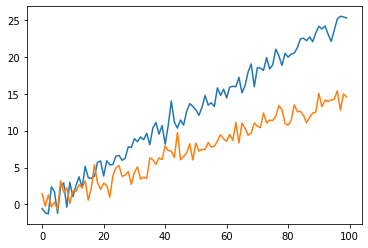

In [4]:
x1 = np.random.normal(size=100) + np.linspace(0, 25, 100)
x2 = np.random.normal(size=100) + np.linspace(0, 15, 100)

plt.plot(x1);
plt.plot(x2);

In [ ]:
np.corrcoef(x1, x2)

array([[1.        , 0.96965385],
       [0.96965385, 1.        ]])

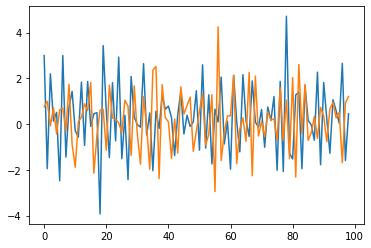

In [ ]:
# differentiate series

dx1 = np.diff(x1)
dx2 = np.diff(x2)

plt.plot(dx1);
plt.plot(dx2);

In [ ]:
np.corrcoef(dx1, dx2)

array([[ 1.        , -0.02100526],
       [-0.02100526,  1.        ]])

## Cross-correlation

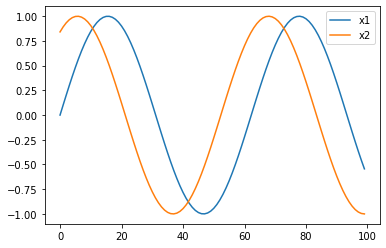

In [ ]:
x1 = np.sin(np.linspace(0, 10, 100))
x2 = np.sin(np.linspace(1, 11, 100))

plt.plot(x1, label='x1');
plt.plot(x2, label='x2');
plt.legend();

In [ ]:
def crosscorr(datax, datay, lag=0):
    return datax.corr(datay.shift(lag))

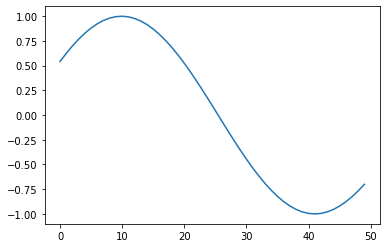

In [ ]:
df = pd.DataFrame(np.vstack((x1, x2)).T, columns=['x1','x2'])
xcov = [crosscorr(df['x1'], df['x2'], lag=i) for i in range(50)]
plt.plot(xcov);

## Cointegration

### Correlation and no cointegration

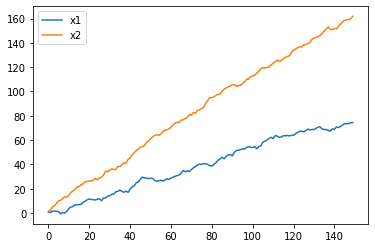

In [ ]:
# perfect correlation, no cointegration

x1 = np.cumsum(np.random.normal(0.5,1,150))
x2 = np.cumsum(np.random.normal(1,1,150))

plt.plot(x1, label='x1');
plt.plot(x2, label='x2');
plt.legend();

In [ ]:
np.corrcoef(x1, x2)

array([[1.        , 0.98389673],
       [0.98389673, 1.        ]])

In [ ]:
def joh_output(res):
    variable = ['r=0'] + [f"r<={i}" for i in range(1,len(res.lr1))]
    output1 = pd.DataFrame([variable, res.lr1,res.cvt[:,0],res.cvt[:,1],res.cvt[:,2]],
                          index=['variable','trace_stat','Crit-90%','Crit-95%','Crit-99%'])
    print(output1.T,'\n')

def stationarity(df):
  """
    Test stationarity in a set of time series.
  
    Parameters:
    df (DataFrame): The time series to be tested columnwise
  
    Returns:
    DataFrame: A dataframe with shape 3 x df.size[1] with the
    result of three statistical tests aiming to answer the question:
    Are the series stationary? 
  
    """

  result_df = pd.DataFrame(np.zeros((2,df.shape[1])),
                           columns= df.columns,
                           index=['ADF', 'KPSS'])

  for i in range(df.shape[1]):

    result_df.iloc[0,i] = adfuller(df.iloc[:,i].values)[1] < 0.05
    result_df.iloc[1,i] = kpss(df.iloc[:,i].values)[1] >= 0.05

  return result_df

In [ ]:
df = pd.DataFrame(np.vstack((x1, x2)).T, columns=['x1','x2'])
stationarity(df)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


,x1,x2
ADF,False,False
KPSS,False,False


In [ ]:
res = coint_johansen(df, 1, 1)
joh_output(res)

  variable trace_stat Crit-90% Crit-95% Crit-99%
0      r=0    221.397  16.1619  18.3985  23.1485
1     r<=1    43.8998   2.7055   3.8415   6.6349 



### Correlation and cointegration

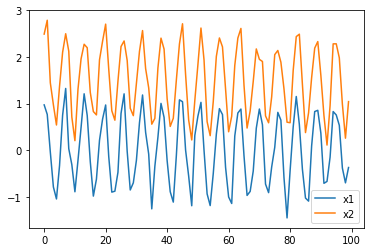

In [ ]:
# high correlation, high cointegration

x1 = np.sin(np.linspace(1,100,100)) + np.random.normal(0,0.2,100)
x2 = np.sin(np.linspace(1,100,100)) + 1.5 + + np.random.normal(0,0.2,100)

plt.plot(x1, label='x1');
plt.plot(x2, label='x2');
plt.legend();

In [ ]:
np.corrcoef(x1, x2)

array([[1.        , 0.93012022],
       [0.93012022, 1.        ]])

In [ ]:
df = pd.DataFrame(np.vstack((x1, x2)).T, columns=['x1','x2'])
stationarity(df)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


,x1,x2
ADF,False,False
KPSS,True,False


In [ ]:
res = coint_johansen(df, 0, 1)
joh_output(res)

  variable trace_stat Crit-90% Crit-95% Crit-99%
0      r=0    220.523  13.4294  15.4943  19.9349
1     r<=1    42.7769   2.7055   3.8415   6.6349 



### No correlation and cointegration

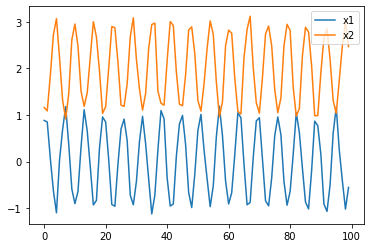

In [ ]:
# No correlation and strong cointegration

x1 = np.sin(np.linspace(1,100,100)) + np.random.normal(0,0.1,100)
x2 = np.sin(np.linspace(1+np.pi,100+np.pi,100)) + 2 + + np.random.normal(0,0.1,100)

plt.plot(x1, label='x1');
plt.plot(x2, label='x2');
plt.legend();

In [ ]:
np.corrcoef(x1, x2)

array([[ 1.        , -0.98126368],
       [-0.98126368,  1.        ]])

In [ ]:
df = pd.DataFrame(np.vstack((x1, x2)).T, columns=['x1','x2'])
stationarity(df)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


,x1,x2
ADF,False,False
KPSS,False,True


In [ ]:
res = coint_johansen(df, 0, 1)
joh_output(res)

  variable trace_stat Crit-90% Crit-95% Crit-99%
0      r=0    295.862  13.4294  15.4943  19.9349
1     r<=1     28.546   2.7055   3.8415   6.6349 

